<h1><b>2CS601 Theory of Computation</b></h1>
<h3> Innovative Assignment </h3>
<h3>Submitted By: 21BCE205, 21BCE209, 21BCE214</h3>

In [ ]:
import json
import sys
from IPython.display import Image

Step - 1: Converting the given regular expression to postfix expression

In [ ]:
def concat(regex):
    new_regex = regex[0]
    for i in range(len(regex)-1):
        c1 = regex[i]
        c2 = regex[i+1]
        if c1 not in ['+', '('] and c2 not in ['*', ')', '+']:
            new_regex += '.'
        new_regex += c2

    return new_regex

In [ ]:
print(concat('(a+b)*c*'))

(a+b)*.c*


In [ ]:
def topostfix(regex):
    shunt = []
    stack = []
    optr = ['*', '.', '+']
    for ch in regex:
        if ch in optr:
            while stack:
                c2 = stack[-1]
                if c2 == '(' or optr.index(c2) > optr.index(ch):
                    break
                else:
                    stack.pop()
                    shunt.append(c2)
            stack.append(ch)
        elif ch == '(':
            stack.append(ch)
        elif ch == ')':
            while stack and stack[-1] != '(':
                ch = stack.pop()
                shunt.append(ch)
            if stack[-1] == '(':
                stack.pop()
        else:  # letter
            shunt.append(ch)
    while stack:
        ch = stack.pop()
        shunt.append(ch)

    return ''.join(shunt)


In [ ]:
print(topostfix(concat('a*b*c*')))

a*b*.c*.


In [ ]:
def postfix(infix):
    new_regex = concat(infix)
    return topostfix(new_regex)

Step - 2: Converting the postfix expression to NFA

In [ ]:
i = 0
class State:
    def __init__(self, edge1=None, edge2=None):
        global i
        self.token = '$'
        self.edge1 = edge1
        self.edge2 = edge2
        self.name = 'Q' + str(i)
        i += 1


In [ ]:
class NFA:
    def __init__(self, start, final):
        self.start = start
        self.final = final

In [ ]:
def kleensclosure(stack):
    nfa1 = stack.pop()

    new_final = State()
    new_start = State(nfa1.start, new_final)

    nfa1.final.edge1 = nfa1.start
    nfa1.final.edge2 = new_final

    new_nfa = NFA(new_start, new_final)
    stack.append(new_nfa)


In [ ]:
def union(stack):
    nfa1 = stack.pop()
    nfa2 = stack.pop()

    new_start = State(nfa1.start, nfa2.start)
    new_final = State()

    nfa1.final.edge1 = new_final
    nfa2.final.edge1 = new_final

    new_nfa = NFA(new_start, new_final)
    stack.append(new_nfa)


In [ ]:
def concatenate(stack):
    nfa2 = stack.pop()
    nfa1 = stack.pop()

    nfa1.final.edge1 = nfa2.start

    new_start = nfa1.start
    new_final = nfa2.final

    new_nfa = NFA(new_start, new_final)
    stack.append(new_nfa)

In [ ]:
def symbol(stack, token):
    final = State()
    start = State(final)
    start.token = token
    new_nfa = NFA(start, final)
    stack.append(new_nfa)

In [ ]:
def toNFA(postex):
    stack = []
    for ch in postex:
        if ch == '*':
            kleensclosure(stack)
        elif ch == '+':
            union(stack)
        elif ch == '.':
            concatenate(stack)
        else:
            symbol(stack, ch)

    return stack[0]


In [ ]:
def visit(state, states, delta):
    if state.name in states:
        return
    states.append(state.name)
    if state.edge1:
        delta.append([state.name, state.token, state.edge1.name])
        visit(state.edge1, states, delta)
    if state.edge2:
        delta.append([state.name, '$', state.edge2.name])
        visit(state.edge2, states, delta)


In [ ]:
def traverse(nfa):
    states = []
    delta = []
    visit(nfa.start, states, delta)
    return states, delta


In [ ]:
def alphabet(delta):
    letters = list(set(edge[1] for edge in delta))
    letters.remove('$')
    return letters


In [ ]:
def convert_dict(nfa):
    states, delta = traverse(nfa)
    result = {
        'states': states,
        'letters': alphabet(delta),
        'transition_function': delta,
        'start_states': [nfa.start.name],
        'final_states': [nfa.final.name]
    }
    return result


In [ ]:
def print_transition_table(data):
    # Define the headers for the table
    headers = ['Source State', 'Input Symbol', 'Destination State']

    # Get the transition function from DFA data
    transition_function = data['transition_function']

    # Print the headers
    print("{:<15} {:<15} {:<15}".format(*headers))
    print("=" * 45)

    # Print the transition table
    for source, symbol, dest in transition_function:
        # Replace '$' with 'ε' for epsilon transitions
        if symbol == '$':
            symbol = 'ε'
        print("{:<15} {:<15} {:<15}".format(str(source), symbol, str(dest)))

In [ ]:
with open('/content/input.json', 'r') as f:
  inp = json.load(f)

regex = inp['regex']
print(regex)
postex = postfix(regex)
nfa = toNFA(postex)
parsed = convert_dict(nfa)

output = json.dumps(parsed, indent=4)
with open('/content/output.json', 'w') as f:
  f.write(output)

(a+b)(a+b)


In [ ]:
import json
from graphviz import Digraph

# Load the JSON data
with open('/content/output.json', 'r') as f:
    nfa_data = json.load(f)

# Create a new Graphviz object
nfa_graph = Digraph(format='png')

# Set the start state
nfa_graph.attr('node', shape='doublecircle')
for state in nfa_data['start_states']:
    nfa_graph.node(state)

# Set the final states
nfa_graph.attr('node', shape='circle')
for state in nfa_data['final_states']:
    nfa_graph.node(state)

# Add the transitions
for transition in nfa_data['transition_function']:
    source_state = transition[0]
    symbol = transition[1]
    dest_state = transition[2]
    if symbol == "$":
        symbol = "ε"
    nfa_graph.edge(source_state, dest_state, label=symbol)

# Render the graph
nfa_graph.render('nfa', view=True)


'nfa.png'

Source State    Input Symbol    Destination State
Q4              ε               Q3             
Q3              b               Q2             
Q2              ε               Q5             
Q5              ε               Q10            
Q10             ε               Q9             
Q9              b               Q8             
Q8              ε               Q11            
Q10             ε               Q7             
Q7              a               Q6             
Q6              ε               Q11            
Q4              ε               Q1             
Q1              a               Q0             
Q0              ε               Q5             


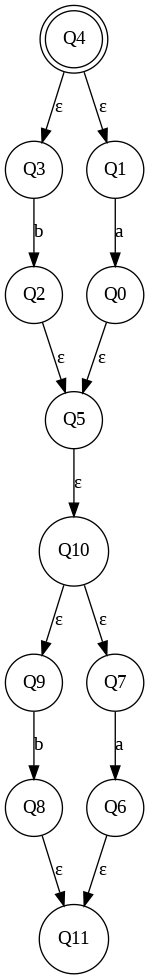

In [ ]:
print_transition_table(nfa_data)
Image(filename='/content/nfa.png')

In [ ]:
# Load the JSON data
with open('/content/output.json', 'r') as f:
    nfa_data = json.load(f)

# Subset Construction Algorithm to convert NFA to DFA
def epsilon_closure(states, delta):
    epsilon_states = set(states)
    queue = list(states)
    while queue:
        current_state = queue.pop(0)
        for edge in delta:
            if edge[0] == current_state and edge[1] == '$':
                new_state = edge[2]
                if new_state not in epsilon_states:
                    epsilon_states.add(new_state)
                    queue.append(new_state)
    return epsilon_states

In [ ]:
def move(states, letter, delta):
    moved_states = set()
    for state in states:
        for edge in delta:
            if edge[0] == state and edge[1] == letter:
                moved_states.add(edge[2])
    return moved_states


In [ ]:
def nfa_to_dfa(nfa_data):
    nfa_states = nfa_data['states']
    alphabet = nfa_data['letters']
    nfa_delta = nfa_data['transition_function']
    nfa_start = nfa_data['start_states']
    nfa_final = nfa_data['final_states']

    dfa_states = []
    dfa_delta = []
    dfa_start = epsilon_closure(nfa_start, nfa_delta)
    dfa_final = []
    queue = [dfa_start]

    while queue:
        current_states = queue.pop(0)
        dfa_states.append(current_states)
        for letter in alphabet:
            new_states = epsilon_closure(move(current_states, letter, nfa_delta), nfa_delta)
            if new_states:
                dfa_delta.append([current_states, letter, new_states])
                if new_states not in dfa_states and new_states not in queue:
                    queue.append(new_states)
        if set(nfa_final) & set(current_states):
            dfa_final.append(current_states)

    return {
        'states': dfa_states,
        'letters': alphabet,
        'transition_function': dfa_delta,
        'start_states': [dfa_start],
        'final_states': dfa_final
    }

In [ ]:
# Convert NFA to DFA
dfa_data = nfa_to_dfa(nfa_data)

# Convert sets to lists in DFA data
dfa_data_serializable = {
    'states': [list(state) for state in dfa_data['states']],
    'letters': dfa_data['letters'],
    'transition_function': [[list(source), letter, list(dest)] for source, letter, dest in dfa_data['transition_function']],
    'start_states': [list(start) for start in dfa_data['start_states']],
    'final_states': [list(final) for final in dfa_data['final_states']]
}

# Write DFA data to a JSON file
output_dfa = json.dumps(dfa_data_serializable, indent=4)
with open('/content/output_dfa.json', 'w') as f:
    f.write(output_dfa)

# Create a new Graphviz object for DFA visualization
dfa_graph = Digraph(format='png')

# Set the start state
dfa_graph.attr('node', shape='doublecircle')
for state in dfa_data['start_states']:
    dfa_graph.node(str(state))

# Set the final states
dfa_graph.attr('node', shape='circle')
for state in dfa_data['final_states']:
    dfa_graph.node(str(state))

# Add the transitions
for transition in dfa_data['transition_function']:
    source_state = str(transition[0])
    symbol = transition[1]
    dest_state = str(transition[2])
    if symbol == "$":
        symbol = "ε"
    dfa_graph.edge(source_state, dest_state, label=symbol)

# Render the DFA graph
dfa_graph.render('dfa', view=True)


'dfa.png'

Source State    Input Symbol    Destination State
{'Q4', 'Q1', 'Q3'} a               {'Q0', 'Q10', 'Q9', 'Q5', 'Q7'}
{'Q4', 'Q1', 'Q3'} b               {'Q2', 'Q10', 'Q9', 'Q5', 'Q7'}
{'Q0', 'Q10', 'Q9', 'Q5', 'Q7'} a               {'Q11', 'Q6'}  
{'Q0', 'Q10', 'Q9', 'Q5', 'Q7'} b               {'Q8', 'Q11'}  
{'Q2', 'Q10', 'Q9', 'Q5', 'Q7'} a               {'Q11', 'Q6'}  
{'Q2', 'Q10', 'Q9', 'Q5', 'Q7'} b               {'Q8', 'Q11'}  


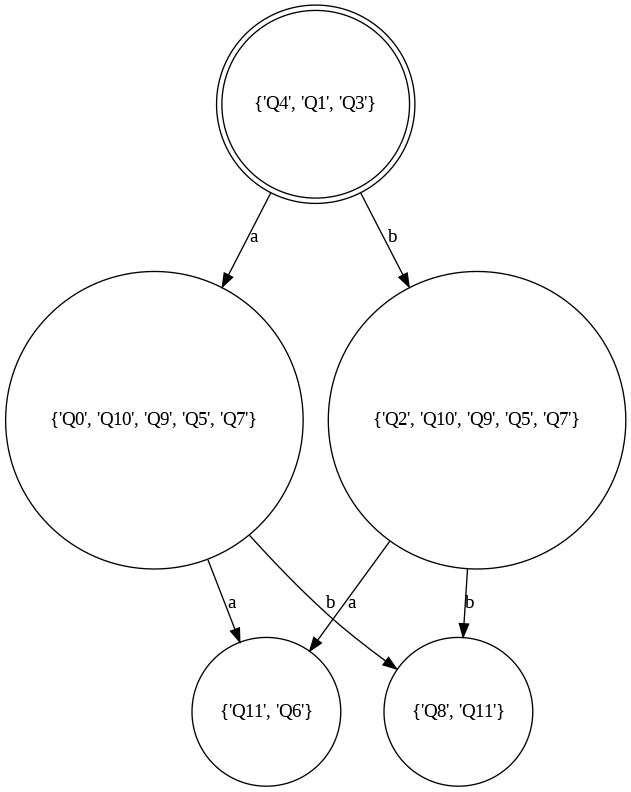

In [ ]:
print_transition_table(dfa_data)
Image(filename='/content/dfa.png')